In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

## Data Cleaning

In [2]:
data = pd.read_csv('ab_data.csv', parse_dates=['timestamp'], index_col='timestamp')
data.head()

,user_id,group,landing_page,converted
timestamp,,,,
2017-01-21 22:11:48.556739,851104,control,old_page,0
2017-01-12 08:01:45.159739,804228,control,old_page,0
2017-01-11 16:55:06.154213,661590,treatment,new_page,0
2017-01-08 18:28:03.143765,853541,treatment,new_page,0
2017-01-21 01:52:26.210827,864975,control,old_page,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 294478 entries, 2017-01-21 22:11:48.556739 to 2017-01-16 12:40:24.467417
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   group         294478 non-null  object
 2   landing_page  294478 non-null  object
 3   converted     294478 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 11.2+ MB


In [4]:
data.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [5]:
# Check for nulls:
data.isnull().sum()

user_id         0
group           0
landing_page    0
converted       0
dtype: int64

In [6]:
#Check for unique users count
data.groupby('group').user_id.nunique()

group
control      146195
treatment    146284
Name: user_id, dtype: int64

In [7]:
#Check if user is in multiple group:
a = data.groupby('user_id').group.nunique() > 1
a[a].index.tolist()

[630320,
 630805,
 630871,
 630887,
 631008,
 631337,
 631459,
 631838,
 632069,
 632464,
 632592,
 632642,
 632690,
 632794,
 633243,
 633692,
 633897,
 633949,
 634098,
 634203,
 634230,
 634552,
 634598,
 634605,
 634611,
 634888,
 634971,
 635003,
 635048,
 635269,
 635737,
 635787,
 635809,
 635984,
 636027,
 636205,
 636280,
 636332,
 636565,
 636583,
 636626,
 636868,
 636909,
 637018,
 637310,
 637315,
 637561,
 637639,
 637900,
 637930,
 638263,
 638525,
 638766,
 639059,
 639090,
 639310,
 639366,
 639386,
 639407,
 639533,
 639635,
 639817,
 640111,
 640253,
 640320,
 640854,
 640909,
 640989,
 641570,
 641751,
 641906,
 642182,
 642372,
 642390,
 642405,
 642972,
 642975,
 643001,
 643076,
 643092,
 643244,
 643404,
 643619,
 643634,
 643701,
 643963,
 644190,
 644225,
 644246,
 644426,
 644510,
 644541,
 644846,
 645276,
 645298,
 645550,
 645584,
 646027,
 646066,
 646077,
 646293,
 646342,
 646406,
 646685,
 647004,
 647055,
 647609,
 647615,
 647844,
 647940,
 648096,
 

In [8]:
data[data.user_id ==630320]

,user_id,group,landing_page,converted
timestamp,,,,
2017-01-07 18:02:43.626318,630320,control,old_page,0
2017-01-12 05:27:37.181803,630320,treatment,old_page,0


In [9]:
data.groupby('group').landing_page.value_counts()

group      landing_page
control    old_page        145274
           new_page          1928
treatment  new_page        145311
           old_page          1965
Name: landing_page, dtype: int64

In [10]:
#There are people in multiple groups, and landing page not served correctly. Let's remove them
data.drop(data[(data['group']=='control') & (data['landing_page']=='new_page')].index, inplace=True) 
data.drop(data[(data['group']=='treatment') & (data['landing_page']=='old_page')].index, inplace=True) 


In [11]:
data.groupby('group').landing_page.value_counts()

group      landing_page
control    old_page        145274
treatment  new_page        145311
Name: landing_page, dtype: int64

In [12]:
#Check again if there are duplicates:
a = data.groupby('user_id').group.nunique() > 1
a[a].index.tolist()

[]

In [13]:
#Plotting treatment vs. control by day:
df_daily = data.groupby('group').resample('D').agg({'user_id':'count', 'converted':'mean'}).unstack(level=0)
df_daily

user_id           converted          
group      control treatment   control treatment
timestamp                                       
2017-01-02    2859      2853  0.125568  0.119874
2017-01-03    6590      6618  0.113809  0.113781
2017-01-04    6578      6541  0.121922  0.116649
2017-01-05    6427      6505  0.123230  0.114988
2017-01-06    6606      6747  0.115350  0.123462
2017-01-07    6604      6609  0.120987  0.116205
2017-01-08    6687      6700  0.118887  0.120746
2017-01-09    6628      6615  0.119644  0.118065
2017-01-10    6654      6696  0.112864  0.126344
2017-01-11    6688      6673  0.118870  0.115091
2017-01-12    6522      6637  0.122048  0.122344
2017-01-13    6552      6508  0.116911  0.111248
2017-01-14    6548      6600  0.126756  0.119242
2017-01-15    6714      6549  0.120494  0.113452
2017-01-16    6591      6545  0.121833  0.119175
2017-01-17    6617      6538  0.122865  0.127256
2017-01-18    6482      6603  0.124807  0.124792
2017-01-19    6578      6552  0.119945  0.117216
2017-01-20    6534      6679  0.115243  0.117682
2017-01-21    6749      6560  0.125945  0.115701
2017-01-22    6596      6669  0.119163  0.118009
2017-01-23    6716      6633  0.125670  0.121061
2017-01-24    3754      3681  0.118007  0.121706

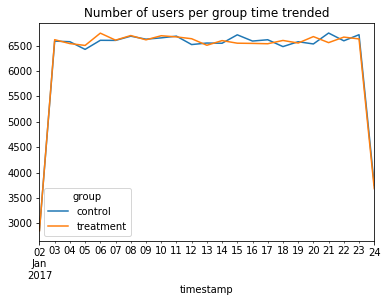

In [14]:
df_daily.plot(kind='line', y='user_id')
plt.title("Number of users per group time trended")
plt.show()

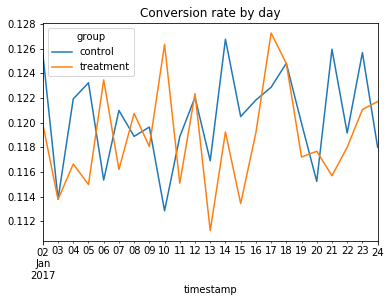

In [15]:
df_daily.plot(kind='line', y='converted')
plt.title("Conversion rate by day")
plt.show()

## Is data normal?

## Check what tests to use

In [16]:
def which_test():
    groups = float(input('How many groups are you testing?'))
    d_type = input("What kind of data is it? (choose from normal, ordinal, categorical)")
    list = ['normal', 'ordinal', 'categorical']
    if d_type not in list:
        print("wrong data type")
    if groups == 1:
        if d_type == "normal":
            print("one-sample t-test")
        elif d_type == "ordinal":
            print("one-sample median")
        elif d_type == "categorical":
            print("binomial test or Chi-square goodness-of-fit")
    elif groups == 2:
        if d_type == "normal":
            print('2 independent sample t-test')
        elif d_type == "ordinal":
            print("Wilcoxon-Mann Whitney test")
        elif d_type == "categorical":
            print("Chi-square test or Fisher’s exact test")
    elif groups > 2:
        if d_type == "normal":
            print('one-way ANOVA')
        elif d_type == "ordinal":
            print("Kruskal Wallis")
        elif d_type == "categorical":
            print("Chi-square test")
    else:
        print("not supported groups")

In [40]:
which_test()

How many groups are you testing?2
What kind of data is it? (choose from normal, ordinal, categorical)categorical
Chi-square test or Fisher’s exact test


## Statistical tests

### Chi-square test

In [47]:
def chi_square_test(df, col1, col2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    values = contingency_table.values
    return chi2_contingency(values)

In [50]:
cont_table = pd.crosstab(data['group'], data['converted'])
print(cont_table)

converted       0      1
group                   
control    127785  17489
treatment  128047  17264


In [20]:
chi2_contingency(cont_table.values)

(1.7053502645115002,
 0.19158976298516003,
 1,
 array([[127899.7125385,  17374.2874615],
        [127932.2874615,  17378.7125385]]))

In [51]:
chi_square_test(data, 'group', 'converted')

(1.7053502645115002,
 0.19158976298516003,
 1,
 array([[127899.7125385,  17374.2874615],
        [127932.2874615,  17378.7125385]]))

### T-test

In [22]:
results = data.groupby('group')['converted'].apply(list)
results

group
control      [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...
treatment    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
Name: converted, dtype: object

In [23]:
print('Difference of Means:')
print((np.mean(results['treatment']) - np.mean(results['control']))/np.mean(results['control']))
ttest_ind(results['treatment'], results['control'], equal_var = False)

Difference of Means:
-0.0131165800315857


Ttest_indResult(statistic=-1.311605949958001, pvalue=0.18965416073470676)

### Z-test

In [36]:
nobs= [cont_table.values[0, 0], cont_table.values[1, 0]]
count=[cont_table.values[0,1], cont_table.values[1,1]]
print(nobs)
print(count)

[127785, 128047]
[17489, 17264]


In [38]:
stat, pval = proportions_ztest(count, nobs)
print('{0:0.3f}'.format(pval))
print(stat)

0.133
1.503720004095709
